# this is to show how double transport affect j_SEI, produce Fig. 7, try solvent diffusion limited SEI

In [16]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/")
Target  = 'OneCycAge_240319_SolDiff/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Save_Fig = True

In [18]:
# define parameter of double and single 
# define parameter of double and single 
Para_dict_Same = {
   "Mesh list":[ [20,10,20,100,20], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   "Contact resistance [Ohm]":[6e-3],
   "Initial Neg SOC":[0.8841301667966484,],
   "Initial Pos SOC":[0.23552755074598045,],
   "Outer SEI solvent diffusivity [m2.s-1]":[1.7e-23,],
}

Para_dict_DD_ONLY = {
   "Model option":[{
      "SEI":"solvent-diffusion limited",   
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,1e-11], # 
}
Para_dict_SD_ONLY = {
   "Model option":[{
      "SEI":"solvent-diffusion limited",   
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,], #  
   "EC diffusivity in electrolyte [m2.s-1]": ["EC_diffusivity_5E_5"],
   "Measured dLJP_dce":["dLJP_1_Specie_dc_e_np",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))


2 1


In [19]:
book_name_xlsx = 'Test.xlsx';sheet_name_xlsx = 'Results';
Path_Exp_Crate =  os.path.expanduser(
    "~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Ruihe_newLGM50_Crate/")
Path_pack = [BasicPath,Target,Path_Exp_Crate,book_name_xlsx,sheet_name_xlsx,];

In [20]:
# Three set of solution:
def Run_OneCycleAge_Dict(index_i, Para_dd_i, Path_pack,):
    count_i = int(index_i);
    [BasicPath,Target,Path_Exp_Crate,
        book_name_xlsx,sheet_name_xlsx,] = Path_pack
    ##### Initialise Para_0 and model 
    CyclePack,para_used = Para_init_Dict(Para_dd_i)
    [Mesh_list,model_options] = CyclePack
    model = pybamm.lithium_ion.DFN(options=model_options)
    str_model_options = str(model_options)
    V_max = 4.2;        V_min = 2.5
    Exp_1  = pybamm.Experiment(
    [ (
        f"Hold at {V_max} V until C/20",
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 1 C until {V_max} V (2 second period)",  # (5 minute period)
        f"Hold at {V_max} V until C/20"),] * 1 )  
    model = Add_var(para_used,model) # add extra variable to model
    var_pts = {
        "x_n": Mesh_list[0],  # negative electrode
        "x_s": Mesh_list[1],  # separator 
        "x_p": Mesh_list[2],  # positive electrode
        "r_n": Mesh_list[3],  # negative particle
        "r_p": Mesh_list[4],  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = Exp_1,
        parameter_values = para_used,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
        )       
    sol    = sim.solve()
    print("Finish!")
    return sol
 
sol_DD_HDx = Run_OneCycleAge_Dict(1.0, Para_DD[1],Path_pack)
sol_DD_LDx = Run_OneCycleAge_Dict(0.0, Para_DD[0],Path_pack)
sol_SD     = Run_OneCycleAge_Dict(2.0, Para_SD[0],Path_pack)

Finish!
Finish!
Finish!


[0.0, 2.0, 4.0, 5.999999999999545, 7.999999999999545, 10.0, 12.0, 14.0, 15.999999999999545, 17.999999999999545, 20.0, 22.0, 24.0, 25.999999999999545, 27.999999999999545, 30.0, 32.0, 34.0, 35.999999999999545, 37.999999999999545, 40.0, 42.0, 44.0, 45.999999999999545, 47.999999999999545, 50.0, 52.0, 54.0, 55.999999999999545, 57.999999999999545, 60.0, 62.0, 64.0, 65.99999999999955, 67.99999999999955, 70.0, 72.0, 74.0, 75.99999999999955, 77.99999999999955, 80.0, 82.0, 84.0, 85.99999999999955, 87.99999999999955, 90.0, 92.0, 94.0, 95.99999999999955, 97.99999999999955, 100.0, 102.0, 104.0, 105.99999999999955, 107.99999999999955, 110.0, 112.0, 114.0, 115.99999999999955, 117.99999999999955, 120.0, 122.0, 124.0, 125.99999999999955, 127.99999999999955, 130.0, 132.0, 134.0, 135.99999999999955, 137.99999999999955, 140.0, 142.0, 144.0, 146.0, 147.99999999999955, 150.0, 152.0, 154.0, 155.99999999999955, 157.99999999999955, 160.0, 162.0, 164.0, 166.0, 167.99999999999955, 170.0, 172.0, 174.0, 175.999999

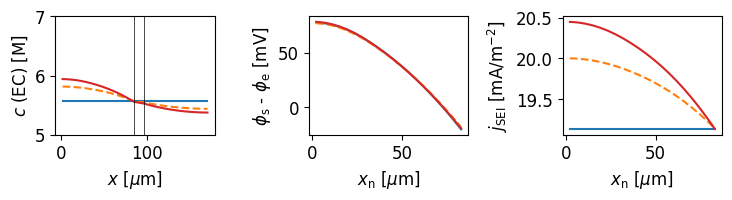

In [21]:
# plot only things happen during 3C CC charge
fs = 12; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
def FindClose(time_DD,t_select): # Input must be a list
    for i in range(0,len(time_DD)):
        if abs(time_DD[i] - t_select)<1e-3:
            break
    return i
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
LS = ['-','--','-','--',];MS=['s','^','h']; ms = 8
Sol_plt = [sol_SD,sol_DD_LDx,sol_DD_HDx,];
Str = ["Single",r"Double low D$_\times$",r"Double high D$_\times$"]

t_int_all = []; Index_t_select = []; 

for i in range(3):
    sol = Sol_plt[i]; step_CC =  sol.cycles[0].steps[2]
    t_int_all.append((
        step_CC['Time [s]'].entries
        - step_CC['Time [s]'].entries[0]).tolist())
    print(t_int_all[-1])
t_select = min(t_int_all[0][-2],t_int_all[1][-2],t_int_all[2][-2])
for i in range(3):
    Index_t_select.append(FindClose(t_int_all[i],t_select))
print(Index_t_select,t_select)

fig, axs = plt.subplots(1,3, figsize=(19/2.54,5.5/2.54),tight_layout=True)
for i in range(3):
    sol = Sol_plt[i]; step_CC =  sol.cycles[0].steps[2]
    x =   step_CC["x [m]"].entries[:,0]
    x_n =   step_CC["x_n [m]"].entries[:,0]
    c_EC =   step_CC["EC concentration [mol.m-3]"].entries[:,Index_t_select[i]]
    j_SEI =   step_CC["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,Index_t_select[i]]
    phi_s_phi_e =   step_CC["Negative electrode surface potential difference [V]"].entries[:,Index_t_select[i]]

    axs[0].plot(x*1e6, c_EC/1e3, color=Colors[i],linestyle=LS[i],) # label=r"Single-High $D_\times$" 
    axs[1].plot(x_n*1e6, phi_s_phi_e*1e3, color=Colors[i],linestyle=LS[i]) 
    axs[2].plot(x_n*1e6, abs(j_SEI)*1e3, color=Colors[i],linestyle=LS[i]) 
Y_0p = np.arange(-100,200,50)
axs[0].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
axs[0].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)


axs[0].set_xlabel(r"$\mathit{x}$ [$\mu$m]",   )
axs[1].set_xlabel(r"$\mathit{x}_\mathrm{n}$ [$\mu$m]",   )
axs[2].set_xlabel(r"$\mathit{x}_\mathrm{n}$ [$\mu$m]",   )
axs[0].set_ylabel("$\mathit{c}$ (EC) [M]")
axs[1].set_ylabel("$\phi$$_\mathrm{s}$ - $\phi$$_\mathrm{e}$ [mV]")
axs[2].set_ylabel("$\mathit{j}_\mathrm{SEI}$ [mA/m$^{-2}$]")
axs[0].ticklabel_format( 
    axis='x', style='sci',
    scilimits=[-1e3,1e3], useOffset=None, 
    useLocale=None, useMathText=None)

axs[0].set_ylim([5.0,7.0])
#axs[1].set_ylim([-90,130])
#axs[2].set_ylim([-0.1,75])
fig.subplots_adjust(wspace=0, hspace=0)
# 85.2 ; 12; 75.6

plt.savefig(BasicPath +  Target+ 
    f"Fig_6_2C_c_EC_j_SEI.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Fig_6_2C_c_EC_j_SEI.svg")   

In [22]:
# Get values for paper:
for i in range(3):
    sol = Sol_plt[i]; step_CC =  sol.cycles[0].steps[2]
    x =   step_CC["x [m]"].entries[:,0]
    x_n =   step_CC["x_n [m]"].entries[:,0]
    c_EC =   step_CC["EC concentration [mol.m-3]"].entries[:,Index_t_select[i]]
    j_SEI =   abs(step_CC[
        "Negative electrode SEI interfacial current density [A.m-2]"].entries[:,Index_t_select[i]])*1e3
    phi_s_phi_e =   step_CC[
        "Negative electrode surface potential difference [V]"].entries[:,Index_t_select[i]]*1e3
    # 
    print(f"For case {Str[i]}")
    print("End time of c(EC) mol/m3 - Neg-CC "
      f"side is {c_EC[0]:.2f}, Pos-CC side is {c_EC[-1]:.2f}")
    print("End time of phi_s_phi_e mV - Neg-CC "
      f"side is {phi_s_phi_e[0]:.2f}, Neg-Sep side is {phi_s_phi_e[-1]:.2f}")
    print("End time of j_SEI mA/m2 - Neg-CC "
      f"side is {j_SEI[0]:.4f}, Neg-Sep side is {j_SEI[-1]:.4f}")
    print("End time of avg(j_SEI) mA/m2"
      f" is {np.mean(j_SEI):.4f}")


For case Single
End time of c(EC) mol/m3 - Neg-CC side is 5576.00, Pos-CC side is 5576.00
End time of phi_s_phi_e mV - Neg-CC side is 77.85, Neg-Sep side is -20.30
End time of j_SEI mA/m2 - Neg-CC side is 19.1296, Neg-Sep side is 19.1296
End time of avg(j_SEI) mA/m2 is 19.1296
For case Double low D$_\times$
End time of c(EC) mol/m3 - Neg-CC side is 5814.28, Pos-CC side is 5438.21
End time of phi_s_phi_e mV - Neg-CC side is 77.14, Neg-Sep side is -18.34
End time of j_SEI mA/m2 - Neg-CC side is 20.0015, Neg-Sep side is 19.1416
End time of avg(j_SEI) mA/m2 is 19.7040
For case Double high D$_\times$
End time of c(EC) mol/m3 - Neg-CC side is 5940.92, Pos-CC side is 5375.05
End time of phi_s_phi_e mV - Neg-CC side is 78.37, Neg-Sep side is -19.52
End time of j_SEI mA/m2 - Neg-CC side is 20.4486, Neg-Sep side is 19.1354
End time of avg(j_SEI) mA/m2 is 19.9854


In [24]:
print((19.9854-19.1296)/19.1296*100)

4.473695215791227


#### For int-diff case
For case Single
End time of c(EC) mol/m3 - Neg-CC side is 6209.49, Pos-CC side is 6209.49
End time of phi_s_phi_e mV - Neg-CC side is 272.56, Neg-Sep side is 79.98
End time of j_SEI mA/m2 - Neg-CC side is 0.0001, Neg-Sep side is 0.1002
End time of avg(j_SEI) mA/m2 is 0.0113
For case Double low D$_\times$
End time of c(EC) mol/m3 - Neg-CC side is 6664.56, Pos-CC side is 5893.02
End time of phi_s_phi_e mV - Neg-CC side is 274.16, Neg-Sep side is 81.14
End time of j_SEI mA/m2 - Neg-CC side is 0.0001, Neg-Sep side is 0.0959
End time of avg(j_SEI) mA/m2 is 0.0112
For case Double high D$_\times$
End time of c(EC) mol/m3 - Neg-CC side is 6842.86, Pos-CC side is 5791.41
End time of phi_s_phi_e mV - Neg-CC side is 277.10, Neg-Sep side is 77.94
End time of j_SEI mA/m2 - Neg-CC side is 0.0001, Neg-Sep side is 0.1084
End time of avg(j_SEI) mA/m2 is 0.0125